# Chargement des données

In [0]:
# On importe les librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler


In [0]:
#On importe le dataset global en précisant qu'il s'agit de time series (squeeze = True)

df = pd.read_csv('https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv',
                 sep = ',', 
                 parse_dates=[0], 
                 index_col=0, 
                 squeeze=True)
df.head()

,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market_Cap,...,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin
GOLD_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7764,7836,7515,7569,17158194786,136829391049,321,0.041416,0.042268,0.040068,0.040425,64184926,1048107282,0.002200,48.91,49.28,47.09,47.48,2678481167,3026175357,2.19,2.80,2.83,2.74,2.76,1537950803,2598670742,0.09,155,156,151,152,6565950868,16589132426,...,111.660,111.66,0.0,216.53,216.53,216.53,216.53,0.0,39.16,39.16,39.160,39.16,0.0,1304.98,1304.980,1304.98,1304.98,0.0,16.61,16.610,16.610,16.61,0.0,2512.405,2512.405,2512.405,2512.405,0.0,134.45,134.45,134.45,134.45,0.0,8.928571,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16
2019-11-29,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7466,7781,7460,7761,19709695456,140280108521,321,0.039227,0.042040,0.039194,0.041423,99506198,1073986624,0.002846,47.09,49.32,47.09,48.88,2944492393,3115330867,2.23,2.64,2.80,2.64,2.80,1899935358,2636173142,0.16,151,156,151,155,7503898278,16887922522,...,111.440,111.66,1798695.0,217.00,218.14,215.78,216.53,1881106.0,39.07,39.51,39.020,39.16,7526362.0,1305.50,1310.205,1303.97,1304.98,392185.0,16.91,16.930,16.570,16.61,1311527.0,2512.405,2512.405,2512.405,2512.405,0.0,133.59,134.51,133.04,134.45,773921.0,9.464286,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16
2019-11-28,1458.0,1455.0,1127.27,1127.35,1323.60,1321.84,7536,7730,7454,7463,19050116751,134879411013,276,0.039129,0.039990,0.038641,0.039190,60743403,1016079672,0.001349,48.00,48.55,47.02,47.06,2662459127,2998875250,1.53,2.69,2.76,2.62,2.64,1514999632,2483560320,0.14,153,156,151,151,7346531960,16496129470,...,111.660,111.66,0.0,218.24,218.24,218.24,218.24,0.0,39.41,39.41,39.410,39.41,0.0,1312.99,1312.990,1312.99,1312.99,0.0,16.91,16.910,16.910,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,133.76,133.76,133.76,133.76,0.0,10.714286,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-27,1459.8,1454.0,1134.12,1129.74,1326.23,1322.30,7220,7619,6974,7531,23991412764,136102712894,645,0.036955,0.039800,0.035783,0.039049,76841561,1012420887,0.004017,47.16,48.52,45.44,48.01,2979663352,3059223170,3.08,2.63,2.73,2.53,2.69,2247567344,2532133843,0.20,148,154,143,153,8778095308,16634910472,...,111.605,111.66,2334424.0,218.67,220.02,217.18,218.24,5314571.0,39.50,39.76,39.080,39.41,33127997.0,1315.00,1318.187,1309.63,1312.99,989345.0,17.01,17.150,16.710,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,135.28,135.70,133.63,133.76,0.0,11.428571,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-26,1458.0,1455.0,1133.76,1131.86,1322.96,1321.11,7145,7320,7098,7218,21129505542,130429018720,222,0.036046,0.037074,0.035705,0.036993,57431470,959117573,0.001369,45.81,47.54,45.66,47.27,2659405400,3012041642,1.88,2.53,2.65,2.53,2.63,1894353525,2479535254,0.12,146,150,145,148,7648516297,16193326033,...,111.850,111.95,3578750.0,220.50,220.69,216.75,217.00,9487105.0,38.99,39.48,38.815,38.99,42706750.0,1309.86,1314.760,1305.09,1313.55,1011135.0,17.11,17.265,16.855,17.01,0.0,2512.405,2512.405,2512.405,2512.405,0.0,136.01,136.15,134.77,135.03,0.0,11.785714,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16


# Exploration des données

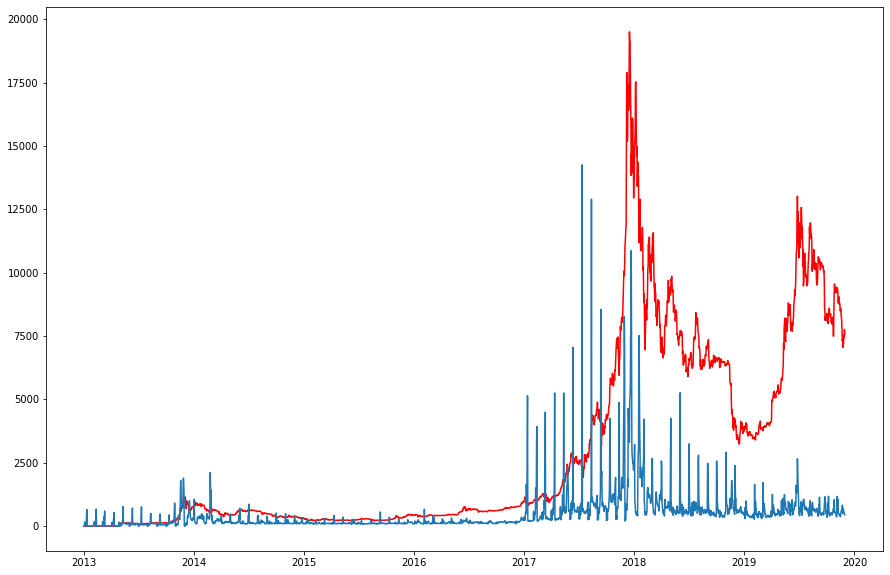

In [0]:
# On affiche Google Trends et le cours du Bitcoin BTC_Close sur le même graphique

plt.figure(figsize=(15,10))
plt.plot(df.BTC_Close, color='r')
plt.plot(df.GGTrends_values*50)
plt.show()

In [0]:
# On affiche les corrélations les plus grandes en valeur absolues

(df.corr()['GGTrends_values']).sort_values(ascending=False)[:20]
# On constate la grande corrélation entre les différents Altcoins et les recherches Google avec le BTC_Close

GGTrends_values    1.000000
BCH_Intraday       0.560564
LTC_Intraday       0.549258
BCH_High           0.549146
BTC_Intraday       0.541021
LTC_High           0.538588
BCH_Close          0.538235
BCH_Market_Cap     0.537260
BCH_Open           0.536933
LTC_Open           0.533697
LTC_Close          0.530479
BCH_Low            0.521463
LTC_Market_Cap     0.519320
LTC_Low            0.515958
ETH_Intraday       0.505709
BTC_High           0.505557
BTC_Open           0.500816
ETH_Market_Cap     0.499351
BTC_Close          0.496963
BTC_Low            0.489511
Name: GGTrends_values, dtype: float64

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


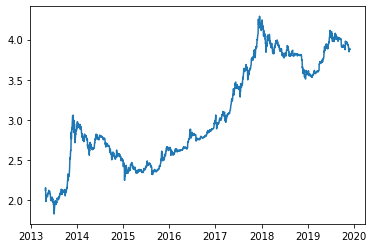

In [0]:
# On affiche le log10 du BTC_Close pour explorer les données
plt.plot(np.log10(df.BTC_Close))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


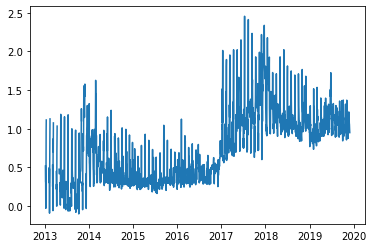

In [0]:
# On affiche également le log10 de Google Trends
plt.plot(np.log10(df.GGTrends_values))

# Préparation des données (Preprocessing)

In [0]:
# On définit une fonction qui récupère pour chaque ligne (date) les nb_day valeurs passées avec un décalage de nb_decal
# et réplique les colonnes val_exp (valeurs explicatives), chacune dans une nouvelle colonne et les juxtapose au colonnes
# contenues dans val_pred qui restent inchangées et non décalées. Cette fonction renvoie un nouveau DataFrame qui contient cette transformation

def Create_Df_Test_dec(df, val_pred, val_exp, nb_day, nb_decal):
    df2 = pd.DataFrame()
    df2['Date'] = df['GOLD_Time']
    
    # On récupère les colonnes à prédire
    for col_pred in val_pred:
        df2[col_pred] = df[col_pred]
    
    # Pour chacune des colonnes indicatives, on va récupérer les n-nb_day valeurs
    for col_exp in val_exp:
        for ii in range(nb_decal-1, nb_day):
            nb_col = ii+1
            new_col = col_exp + '_' + str(nb_col)
            df2[new_col] = 0.0
            for jj in range(len(df)):
                if ((jj+ii+1) >= len(df)):
                    df2[new_col].values[jj] = np.nan
                else:
                    df2[new_col].values[jj] = (df[col_exp].values[jj+ii+1])
    df2 = df2.set_index('Date')    
    return df2

In [0]:
# On charge à nouveau le fichier dans un DataFrame en précisant qu'il s'agit d'un TimeSeries de la colonne 0. On ne définit pas d'Index.
df_in = pd.read_csv('https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv',
                 sep = ',', 
                 parse_dates=[0], 
                 squeeze=True)
df_in.head()

,GOLD_Time,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,...,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin
0,2019-11-30,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7764,7836,7515,7569,17158194786,136829391049,321,0.041416,0.042268,0.040068,0.040425,64184926,1048107282,0.002200,48.91,49.28,47.09,47.48,2678481167,3026175357,2.19,2.80,2.83,2.74,2.76,1537950803,2598670742,0.09,155,156,151,152,6565950868,...,111.660,111.66,0.0,216.53,216.53,216.53,216.53,0.0,39.16,39.16,39.160,39.16,0.0,1304.98,1304.980,1304.98,1304.98,0.0,16.61,16.610,16.610,16.61,0.0,2512.405,2512.405,2512.405,2512.405,0.0,134.45,134.45,134.45,134.45,0.0,8.928571,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16
1,2019-11-29,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7466,7781,7460,7761,19709695456,140280108521,321,0.039227,0.042040,0.039194,0.041423,99506198,1073986624,0.002846,47.09,49.32,47.09,48.88,2944492393,3115330867,2.23,2.64,2.80,2.64,2.80,1899935358,2636173142,0.16,151,156,151,155,7503898278,...,111.440,111.66,1798695.0,217.00,218.14,215.78,216.53,1881106.0,39.07,39.51,39.020,39.16,7526362.0,1305.50,1310.205,1303.97,1304.98,392185.0,16.91,16.930,16.570,16.61,1311527.0,2512.405,2512.405,2512.405,2512.405,0.0,133.59,134.51,133.04,134.45,773921.0,9.464286,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16
2,2019-11-28,1458.0,1455.0,1127.27,1127.35,1323.60,1321.84,7536,7730,7454,7463,19050116751,134879411013,276,0.039129,0.039990,0.038641,0.039190,60743403,1016079672,0.001349,48.00,48.55,47.02,47.06,2662459127,2998875250,1.53,2.69,2.76,2.62,2.64,1514999632,2483560320,0.14,153,156,151,151,7346531960,...,111.660,111.66,0.0,218.24,218.24,218.24,218.24,0.0,39.41,39.41,39.410,39.41,0.0,1312.99,1312.990,1312.99,1312.99,0.0,16.91,16.910,16.910,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,133.76,133.76,133.76,133.76,0.0,10.714286,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16
3,2019-11-27,1459.8,1454.0,1134.12,1129.74,1326.23,1322.30,7220,7619,6974,7531,23991412764,136102712894,645,0.036955,0.039800,0.035783,0.039049,76841561,1012420887,0.004017,47.16,48.52,45.44,48.01,2979663352,3059223170,3.08,2.63,2.73,2.53,2.69,2247567344,2532133843,0.20,148,154,143,153,8778095308,...,111.605,111.66,2334424.0,218.67,220.02,217.18,218.24,5314571.0,39.50,39.76,39.080,39.41,33127997.0,1315.00,1318.187,1309.63,1312.99,989345.0,17.01,17.150,16.710,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,135.28,135.70,133.63,133.76,0.0,11.428571,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16
4,2019-11-26,1458.0,1455.0,1133.76,1131.86,1322.96,1321.11,7145,7320,7098,7218,21129505542,130429018720,222,0.036046,0.037074,0.035705,0.036993,57431470,959117573,0.001369,45.81,47.54,45.66,47.27,2659405400,3012041642,1.88,2.53,2.65,2.53,2.63,1894353525,2479535254,0.12,146,150,145,148,7648516297,...,111.850,111.95,3578750.0,220.50,220.69,216.75,217.00,9487105.0,38.99,39.48,38.815,38.99,42706750.0,1309.86,1314.760,1305.09,1313.55,1011135.0,17.11,17.265,16.855,17.01,0.0,2512.405,2512.405,2512.405,2512.405,0.0,136.01,136.15,134.77,135.03,0.0,11.785714,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16


In [72]:
# On précise les colonnes à répliquer et les colonnes à garder dans les deux listes val_pred et val_exp. La première colonne dans l'ordre de val_pred sera la valeur à prédire.
val_pred = ['BTC_Close', 'Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']
val_exp = ['BTC_Close', 'BTC_Intraday', 'BTC_Volume', 'BTC_Market_Cap',
           'NVIDIA_Close', 'AMD_Close', 'GOOGLE_Close', 'GPS_Close', 'IBM_Close', #Actions \
           'GOLD_USD_PM', # Or \
           'EURGBP_Close', 'EURHUF_Close', 'EURJPY_Close', 'EURUSD_Close', 'CNYUSD_Close', 'GBPUSD_Close', # FOREX \
           'IBB_Close', 'ICE_Close', 'IEF_Close',# INDEX
           'GGTrends_values'] #Google Trends

#On fait appel à la fonction pour transformer notre DataFrame et l'enregistrer dans df_out
df_out = Create_Df_Test_dec(df_in, val_pred, val_exp, 8, 1)

df_out.head(5)

,BTC_Close,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_1,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_1,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_1,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_1,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_1,...,GBPUSD_Close_1,GBPUSD_Close_2,GBPUSD_Close_3,GBPUSD_Close_4,GBPUSD_Close_5,GBPUSD_Close_6,GBPUSD_Close_7,GBPUSD_Close_8,IBB_Close_1,IBB_Close_2,IBB_Close_3,IBB_Close_4,IBB_Close_5,IBB_Close_6,IBB_Close_7,IBB_Close_8,ICE_Close_1,ICE_Close_2,ICE_Close_3,ICE_Close_4,ICE_Close_5,ICE_Close_6,ICE_Close_7,ICE_Close_8,IEF_Close_1,IEF_Close_2,IEF_Close_3,IEF_Close_4,IEF_Close_5,IEF_Close_6,IEF_Close_7,IEF_Close_8,GGTrends_values_1,GGTrends_values_2,GGTrends_values_3,GGTrends_values_4,GGTrends_values_5,GGTrends_values_6,GGTrends_values_7,GGTrends_values_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,7569,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,7761.0,7463.0,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,321.0,276.0,645.0,222.0,702.0,379.0,291.0,761.0,1.970970e+10,1.905012e+10,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,1.402801e+11,1.348794e+11,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,216.53,...,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,119.39,119.39,119.39,118.48,118.25,115.41,115.41,115.41,94.17,93.44,93.44,94.50,94.31,93.76,93.76,93.76,111.66,111.66,111.66,111.95,111.74,111.69,111.69,111.69,9.464286,10.714286,11.428571,11.785714,13.750000,10.000000,12.826087,16.521739
2019-11-29,7761,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,7463.0,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,276.0,645.0,222.0,702.0,379.0,291.0,761.0,513.0,1.905012e+10,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,1.348794e+11,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,218.24,...,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,119.39,119.39,118.48,118.25,115.41,115.41,115.41,114.30,93.44,93.44,94.50,94.31,93.76,93.76,93.76,93.88,111.66,111.66,111.95,111.74,111.69,111.69,111.69,111.71,10.714286,11.428571,11.785714,13.750000,10.000000,12.826087,16.521739,13.695652
2019-11-28,7463,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,645.0,222.0,702.0,379.0,291.0,761.0,513.0,227.0,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,218.24,...,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,119.39,118.48,118.25,115.41,115.41,115.41,114.30,113.96,93.44,94.50,94.31,93.76,93.76,93.76,93.88,94.46,111.66,111.95,111.74,111.69,111.69,111.69,111.71,111.99,11.428571,11.785714,13.750000,10.000000,12.826087,16.521739,13.695652,11.304348
2019-11-27,7531,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,8206.0,222.0,702.0,379.0,291.0,761.0,513.0,227.0,309.0,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,2.108361e+10,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,1.481784e+11,217.00,...,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,118.48,118.25,115.41,115.41,115.41,114.30,113.96,113.45,94.50,94.31,93.76,93.76,93.76,93.88,94.46,93.99,111.95,111.74,111.69,111.69,111.69,111.71,111.99,111.58,11.785714,13.750000,10.000000,12.826087,16.521739,13.695652,11.304348,12.391304
2019-11-26,7218,-0.222521,0.974928,0.86

In [0]:
# On remplace les NaN et les 0 par 1
df_out = df_out.fillna(1)
df_out = df_out.replace(0, 1)

In [0]:
# On définit une fonction qui applique log10 sur les données explicatives
def log10_transform(df, excluded):
  df_log = pd.DataFrame(index=df.index)
  for col in df.columns:
    if col in excluded:
      df_log[col] = df[col]
    else:
      df_log[col] = np.log10(df[col])
  return df_log

In [80]:
# On applique le log10 sur les données explicatives sauf les jours

excluded = ['Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']
df_log = log10_transform(df_out, excluded)
df_log.head()

,BTC_Close,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_1,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_1,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_1,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_1,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_1,...,GBPUSD_Close_1,GBPUSD_Close_2,GBPUSD_Close_3,GBPUSD_Close_4,GBPUSD_Close_5,GBPUSD_Close_6,GBPUSD_Close_7,GBPUSD_Close_8,IBB_Close_1,IBB_Close_2,IBB_Close_3,IBB_Close_4,IBB_Close_5,IBB_Close_6,IBB_Close_7,IBB_Close_8,ICE_Close_1,ICE_Close_2,ICE_Close_3,ICE_Close_4,ICE_Close_5,ICE_Close_6,ICE_Close_7,ICE_Close_8,IEF_Close_1,IEF_Close_2,IEF_Close_3,IEF_Close_4,IEF_Close_5,IEF_Close_6,IEF_Close_7,IEF_Close_8,GGTrends_values_1,GGTrends_values_2,GGTrends_values_3,GGTrends_values_4,GGTrends_values_5,GGTrends_values_6,GGTrends_values_7,GGTrends_values_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,3.879039,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,3.889918,3.872913,3.876853,3.858417,3.854063,3.848004,3.869056,3.863085,2.506505,2.440909,2.809560,2.346353,2.846337,2.578639,2.463893,2.881385,10.294680,10.279898,10.380056,10.324889,10.630278,10.483352,10.322404,10.534563,11.146996,11.129946,11.133867,11.115374,11.110970,11.104922,11.125924,11.119888,2.335518,...,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,2.076968,2.076968,2.076968,2.073645,2.072801,2.062243,2.062243,2.062243,1.973913,1.970533,1.970533,1.975432,1.974558,1.972018,1.972018,1.972018,2.047898,2.047898,2.047898,2.049024,2.048209,2.048014,2.048014,2.048014,0.976088,1.029963,1.057992,1.071356,1.138303,1.000000,1.108094,1.218056
2019-11-29,3.889918,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,3.872913,3.876853,3.858417,3.854063,3.848004,3.869056,3.863085,3.883207,2.440909,2.809560,2.346353,2.846337,2.578639,2.463893,2.881385,2.710117,10.279898,10.380056,10.324889,10.630278,10.483352,10.322404,10.534563,10.352457,11.129946,11.133867,11.115374,11.110970,11.104922,11.125924,11.119888,11.139979,2.338934,...,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,2.076968,2.076968,2.073645,2.072801,2.062243,2.062243,2.062243,2.058046,1.970533,1.970533,1.975432,1.974558,1.972018,1.972018,1.972018,1.972573,2.047898,2.047898,2.049024,2.048209,2.048014,2.048014,2.048014,2.048092,1.029963,1.057992,1.071356,1.138303,1.000000,1.108094,1.218056,1.136583
2019-11-28,3.872913,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,3.876853,3.858417,3.854063,3.848004,3.869056,3.863085,3.883207,3.904553,2.809560,2.346353,2.846337,2.578639,2.463893,2.881385,2.710117,2.356026,10.380056,10.324889,10.630278,10.483352,10.322404,10.534563,10.352457,10.317317,11.133867,11.115374,11.110970,11.104922,11.125924,11.119888,11.139979,11.161256,2.338934,...,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,2.076968,2.073645,2.072801,2.062243,2.062243,2.062243,2.058046,2.056752,1.970533,1.975432,1.974558,1.972018,1.972018,1.972018,1.972573,1.975248,2.047898,2.049024,2.048209,2.048014,2.048014,2.048014,2.048092,2.049179,1.057992,1.071356,1.138303,1.000000,1.108094,1.218056,1.136583,1.053246
2019-11-27,3.876853,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,3.858417,3.854063,3.848004,3.869056,3.863085,3.883207,3.904553,3.914132,2.346353,2.846337,2.578639,2.463893,2.881385,2.710117,2.356026,2.489958,10.324889,10.630278,10.483352,10.322404,10.534563,10.352457,10.317317,10.323945,11.115374,11.110970,11.104922,11.125924,11.119888,11.139979,11.161256,11.170785,2.336460,...,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,2.073645,2.072801,2.062243,2.062243,2.062243,2.058046,2.056752,2.054805,1.975432,1.974558,1.972018,1.972018,1.

In [81]:
# On divise en data (explicatives) et target
data = df_log.iloc[:, 1:]
target = df_log['BTC_Close']
data.head()

,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_1,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_1,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_1,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_1,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_1,NVIDIA_Close_2,...,GBPUSD_Close_1,GBPUSD_Close_2,GBPUSD_Close_3,GBPUSD_Close_4,GBPUSD_Close_5,GBPUSD_Close_6,GBPUSD_Close_7,GBPUSD_Close_8,IBB_Close_1,IBB_Close_2,IBB_Close_3,IBB_Close_4,IBB_Close_5,IBB_Close_6,IBB_Close_7,IBB_Close_8,ICE_Close_1,ICE_Close_2,ICE_Close_3,ICE_Close_4,ICE_Close_5,ICE_Close_6,ICE_Close_7,ICE_Close_8,IEF_Close_1,IEF_Close_2,IEF_Close_3,IEF_Close_4,IEF_Close_5,IEF_Close_6,IEF_Close_7,IEF_Close_8,GGTrends_values_1,GGTrends_values_2,GGTrends_values_3,GGTrends_values_4,GGTrends_values_5,GGTrends_values_6,GGTrends_values_7,GGTrends_values_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,3.889918,3.872913,3.876853,3.858417,3.854063,3.848004,3.869056,3.863085,2.506505,2.440909,2.809560,2.346353,2.846337,2.578639,2.463893,2.881385,10.294680,10.279898,10.380056,10.324889,10.630278,10.483352,10.322404,10.534563,11.146996,11.129946,11.133867,11.115374,11.110970,11.104922,11.125924,11.119888,2.335518,2.338934,...,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,2.076968,2.076968,2.076968,2.073645,2.072801,2.062243,2.062243,2.062243,1.973913,1.970533,1.970533,1.975432,1.974558,1.972018,1.972018,1.972018,2.047898,2.047898,2.047898,2.049024,2.048209,2.048014,2.048014,2.048014,0.976088,1.029963,1.057992,1.071356,1.138303,1.000000,1.108094,1.218056
2019-11-29,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,3.872913,3.876853,3.858417,3.854063,3.848004,3.869056,3.863085,3.883207,2.440909,2.809560,2.346353,2.846337,2.578639,2.463893,2.881385,2.710117,10.279898,10.380056,10.324889,10.630278,10.483352,10.322404,10.534563,10.352457,11.129946,11.133867,11.115374,11.110970,11.104922,11.125924,11.119888,11.139979,2.338934,2.338934,...,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,2.076968,2.076968,2.073645,2.072801,2.062243,2.062243,2.062243,2.058046,1.970533,1.970533,1.975432,1.974558,1.972018,1.972018,1.972018,1.972573,2.047898,2.047898,2.049024,2.048209,2.048014,2.048014,2.048014,2.048092,1.029963,1.057992,1.071356,1.138303,1.000000,1.108094,1.218056,1.136583
2019-11-28,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,3.876853,3.858417,3.854063,3.848004,3.869056,3.863085,3.883207,3.904553,2.809560,2.346353,2.846337,2.578639,2.463893,2.881385,2.710117,2.356026,10.380056,10.324889,10.630278,10.483352,10.322404,10.534563,10.352457,10.317317,11.133867,11.115374,11.110970,11.104922,11.125924,11.119888,11.139979,11.161256,2.338934,2.336460,...,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,2.076968,2.073645,2.072801,2.062243,2.062243,2.062243,2.058046,2.056752,1.970533,1.975432,1.974558,1.972018,1.972018,1.972018,1.972573,1.975248,2.047898,2.049024,2.048209,2.048014,2.048014,2.048014,2.048092,2.049179,1.057992,1.071356,1.138303,1.000000,1.108094,1.218056,1.136583,1.053246
2019-11-27,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,3.858417,3.854063,3.848004,3.869056,3.863085,3.883207,3.904553,3.914132,2.346353,2.846337,2.578639,2.463893,2.881385,2.710117,2.356026,2.489958,10.324889,10.630278,10.483352,10.322404,10.534563,10.352457,10.317317,10.323945,11.115374,11.110970,11.104922,11.125924,11.119888,11.139979,11.161256,11.170785,2.336460,2.344805,...,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,0.102276,2.073645,2.072801,2.062243,2.062243,2.062243,2.058046,2.056752,2.054805,1.975432,1.974558,1.972018,1.9720

In [0]:
#On définit une fonction qui normalise les données explicatives sauf les colonnes relatives aux dates (seasonality)

def std_scaler(data, seasonality):
  scaler = StandardScaler()

  transformed_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
  data.head()

  for season in seasonality:
    transformed_data[season] = df_out[season]

  return transformed_data

In [84]:
#On définit la liste des colonnes à ne pas scaler, puis on scale les données avec la fonction

excluded_col = ['Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']

scaled_data = std_scaler(data_log, excluded_col)

scaled_data.head()

,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_1,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_1,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_1,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_1,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_1,NVIDIA_Close_2,...,GBPUSD_Close_1,GBPUSD_Close_2,GBPUSD_Close_3,GBPUSD_Close_4,GBPUSD_Close_5,GBPUSD_Close_6,GBPUSD_Close_7,GBPUSD_Close_8,IBB_Close_1,IBB_Close_2,IBB_Close_3,IBB_Close_4,IBB_Close_5,IBB_Close_6,IBB_Close_7,IBB_Close_8,ICE_Close_1,ICE_Close_2,ICE_Close_3,ICE_Close_4,ICE_Close_5,ICE_Close_6,ICE_Close_7,ICE_Close_8,IEF_Close_1,IEF_Close_2,IEF_Close_3,IEF_Close_4,IEF_Close_5,IEF_Close_6,IEF_Close_7,IEF_Close_8,GGTrends_values_1,GGTrends_values_2,GGTrends_values_3,GGTrends_values_4,GGTrends_values_5,GGTrends_values_6,GGTrends_values_7,GGTrends_values_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,1.082690,1.063454,1.067560,1.046836,1.041773,1.034847,1.057860,1.051053,1.175147,1.097524,1.538416,0.986460,1.583749,1.265453,1.129389,1.627862,0.929880,0.925686,0.957642,0.940767,1.037093,0.991466,0.941486,1.008382,0.612152,0.604348,0.605844,0.597502,0.595386,0.592578,0.601547,0.598765,1.257245,1.263437,...,1.377017,1.378218,1.37942,1.380624,1.38183,1.383038,1.384247,1.385459,1.018945,0.959445,0.910801,0.843129,0.803286,0.696544,0.674808,0.655696,-0.590413,-0.592428,-0.581230,-0.551447,-0.544633,-0.544384,-0.534756,-0.525444,1.410998,1.412252,1.413508,1.415940,1.416350,1.417409,1.418673,1.419938,0.601088,0.720404,0.782768,0.812839,0.960846,0.657237,0.895613,1.138090
2019-11-29,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,1.063719,1.067841,1.047068,1.042006,1.035063,1.058117,1.051271,1.073215,1.096759,1.537901,0.985315,1.583367,1.264304,1.128546,1.627342,1.423668,0.925223,0.957209,0.940294,1.036716,0.990971,0.940984,1.007974,0.951362,0.604586,0.606081,0.597697,0.595568,0.592741,0.601733,0.598926,0.607462,1.264456,1.263437,...,1.377017,1.378218,1.37942,1.380624,1.38183,1.383038,1.384247,1.385459,1.018945,0.959445,0.882294,0.836265,0.721455,0.696544,0.674808,0.626888,-0.604075,-0.592428,-0.561975,-0.554837,-0.554355,-0.544384,-0.534756,-0.523396,1.410998,1.412252,1.414682,1.415090,1.416148,1.417409,1.418673,1.420019,0.719844,0.782162,0.812204,0.960242,0.656436,0.895088,1.137481,0.958941
2019-11-28,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,1.068114,1.047311,1.042228,1.035283,1.058377,1.051517,1.073474,1.096726,1.537304,0.984571,1.582331,1.263775,1.127376,1.626665,1.423067,1.001499,0.956775,0.939846,1.036326,0.990554,0.940448,1.007528,0.950905,0.940359,0.606326,0.597905,0.595757,0.592913,0.601928,0.599102,0.607653,0.616672,1.264456,1.258225,...,1.377017,1.378218,1.37942,1.380624,1.38183,1.383038,1.384247,1.385459,1.018945,0.929181,0.875054,0.750396,0.721455,0.696544,0.644905,0.618008,-0.604075,-0.572904,-0.565410,-0.564688,-0.554355,-0.544384,-0.532682,-0.513532,1.410998,1.413426,1.413832,1.414887,1.416148,1.417409,1.418754,1.421154,0.781627,0.811608,0.959659,0.655728,0.894356,1.137049,0.958275,0.775692
2019-11-27,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,1.047545,1.042462,1.035494,1.058640,1.051764,1.073760,1.097027,1.107275,0.983762,1.581834,1.262681,1.126785,1.625571,1.422322,1.000733,1.161182,0.939396,1.035963,0.990124,0.939986,1.007047,0.950410,0.939892,0.942435,0.598120,0.595958,0.593092,0.602133,0.599288,0.607859,0.616895,0.620797,1.259232,1.275800,...,1.377017,1.378218,1.37942,1.380624,1.38183,1.383038,1.384247,1.385459,0.986552,0.921495,0.784479,0.750396,0.721455,0.665409,0.635687,0.604638,-0.584272,-0.576387,-0.575394,-0.564688,-0.554355,-0.542285,-0.522699,-0.521521,1

# X_train, y_train, X_test, y_test

In [0]:
# On découpe les données en échantillon d'entrainement et échantillon de test. Ici on a choisit les time_window=100 dernières valeurs dans le temps comme échantillon de test.
# On peu aussi découper les données de façon aléatoire avec train_test_split si on veut.

time_window = 100

y_train = np.asarray(target)[time_window:]
y_test = target[:time_window]
X_train = np.asarray(scaled_data)[time_window:, :]
X_test = np.asarray(scaled_data)[:time_window, :]

# Modèle de prédiction

In [0]:
# importation des librairies
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold 

In [87]:
# On instancie le predicteur
dnorm = xgb.DMatrix(scaled_data, label=target)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=dnorm, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [88]:
# On l'entraine sur le set d'entrainement

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

best_nrounds = cv_results.shape[0] - 1

gbdt = xgb.train(params, dtrain, best_nrounds)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
# On prédit les valeurs pour l'échantillon de test (y_pred) et pour l'échantillon d'entrainement (y_train_pred)
y_pred = gbdt.predict(dtest)
y_train_pred = gbdt.predict(dtrain)

In [0]:
# On transforme par puissance de 10 (inverse de log10)
y_pred = 10**y_pred
y_train_pred = 10**y_train_pred


# Evaluation des résultats

In [91]:
# On affiche la racine de l'erreur quadratique moyenne

print("La racine carrée de l'erreur quadratique moyenne sur les données d'entrainement : ", np.round(np.sqrt(mean_squared_error(y_train_pred, y_train))))
print("La racine carrée de l'erreur quadratique moyenne sur les données de test : ", np.round(np.sqrt(mean_squared_error(y_pred, y_test))))

La racine carrée de l'erreur quadratique moyenne sur les données d'entrainement :  3721.0
La racine carrée de l'erreur quadratique moyenne sur les données de test :  8252.0


In [92]:
# On crée un DataFrame qui contient les valeurs prédites et les valeurs réelles pour l'échantillon de test
df_result = pd.DataFrame()
df_result['BTC_Close_Reel'] = 10**y_test
df_result['BTC_Close_Pred'] = y_pred
df_result.head(10)

,BTC_Close_Reel,BTC_Close_Pred
Date,,
2019-11-30,7569.0,7192.895996
2019-11-29,7761.0,7192.895996
2019-11-28,7463.0,7192.895996
2019-11-27,7531.0,6922.103516
2019-11-26,7218.0,6976.999512
2019-11-25,7146.0,7249.939941
2019-11-24,7047.0,7506.446777
2019-11-23,7397.0,7506.446777
2019-11-22,7296.0,7506.446777


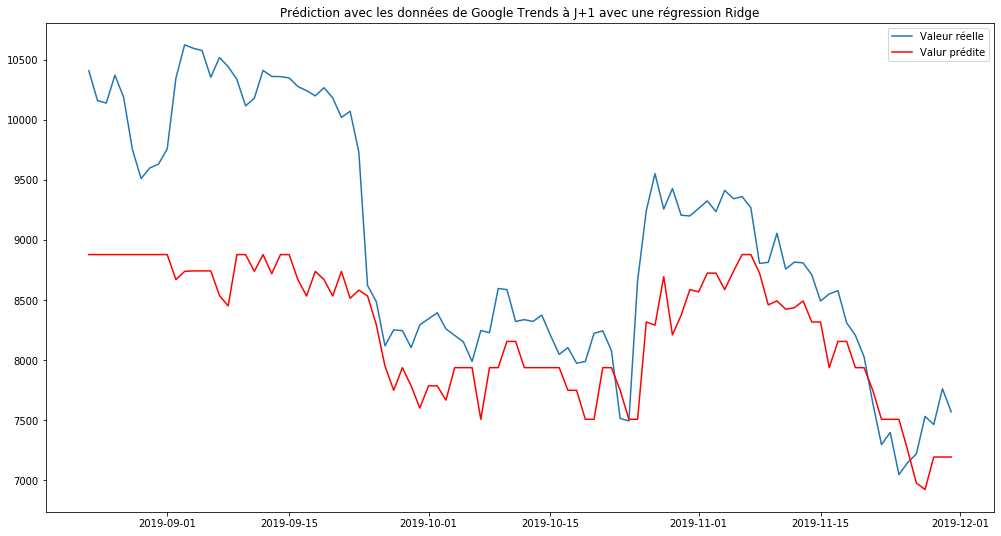

In [93]:
# On affiche les deux courbes pour comparer
plt.figure(figsize=(17, 9))
plt.plot(df_result.index, df_result['BTC_Close_Reel'], label='Valeur réelle')
plt.plot(df_result.index, df_result['BTC_Close_Pred'], color='r', label='Valur prédite')
plt.title('Prédiction avec les données de Google Trends à J+1 avec une régression Ridge')
plt.legend()
plt.show()